# Setup libraries

In [1]:
!pip install --upgrade pip
!pip uninstall -y transformers tokenizers accelerate -q
!pip install "transformers==4.56.0" "protobuf==5.29.3" -q
!pip install torch datasets -q
!pip install pandas matplotlib seaborn tqdm wandb pyyaml
!pip install bitsandbytes accelerate
# !pip install -r requirements.txt
!pip install --force-reinstall --no-cache-dir "numpy<2.0"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 22.9 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.12.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
peft 0.16.0 requires accelerate>=0.21.0, which is not installed.
google-cloud-translate 3.12.1 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.19.5, but you have protobuf 5.29.3 which is incompatible.
a2a-sdk 0.3.10 requires protobuf>=5.29.5, but you have protobuf 5.29.3 which is incompatible.
ray 2.51.1 requires click!=8.3.0,>=7.0, but you have click 8.3.0 which is incompatible.
bigframes 2.12.0 requires rich<14,>=12.4.4, but you have rich

# Supress warnings

In [2]:
# Suppress warnings for clean output
import warnings
import os
warnings.filterwarnings("ignore", category=UserWarning)
os.environ["TRANSFORMERS_NO_ADVISORY_WARNINGS"] = "true"
print("✅ Packages installed successfully!")

✅ Packages installed successfully!


# Install Libraries

In [3]:
"Built-in libraries"
import re
import sys
import gc
import time
import json
import hashlib
import glob
import zipfile
from io import StringIO
from datetime import datetime
from typing import Dict, List, Optional, Tuple, Any
import yaml
import logging
import random

"Deep learning and NLP libraries"
import torch
import torch.nn.functional as F
from transformers import (
    AutoConfig,
    AutoTokenizer,
    AutoModelForCausalLM,
    BitsAndBytesConfig,
    GenerationConfig,
    logging as hf_logging
)

"Data processing libraries"
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import wandb
from tqdm.auto import tqdm
from IPython import get_ipython

# Configure logging
logging.getLogger("ContinuousBatchingLogger").setLevel(logging.ERROR)
hf_logging.set_verbosity_error()


print(f"Python Version: {sys.version}")
print(f"PyTorch Version: {torch.__version__}")
print(f"CUDA Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA Version: {torch.version.cuda}")
!nvidia-smi

Python Version: 3.11.13 (main, Jun  4 2025, 08:57:29) [GCC 11.4.0]
PyTorch Version: 2.6.0+cu124
CUDA Available: True
CUDA Version: 12.4
Sat Dec 20 16:51:57 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.172.08             Driver Version: 570.172.08     CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   31C    P8             10W /   70W |       3MiB /  15360MiB |      0%      Default |
|   

In [4]:
import os
def configure_environment_paths():
    """Detect environment and configure paths"""
    try:
        if "google.colab" in str(get_ipython()):
            print("✅ Environment: Google Colab")
            base_data_path = "/content/"
            base_output_path = "/content/"
            environment_name = "colab"
        elif os.environ.get("KAGGLE_KERNEL_RUN_TYPE"):
            print("✅ Environment: Kaggle")
            base_data_path = "/kaggle/input/"
            base_output_path = "/kaggle/working/"
            environment_name = "kaggle"
        else:
            print("⚠️ Environment: Local/Unknown")
            base_data_path = "./data/"
            base_output_path = "./output/"
            environment_name = "local"
    except NameError:
        print("⚠️ Non-interactive session. Using local paths.")
        base_data_path = "./data/"
        base_output_path = "./output/"
        environment_name = "local"

    os.makedirs(base_output_path, exist_ok=True)
    print(f"📂 Data Path: {base_data_path}")
    print(f"📦 Output Path: {base_output_path}")

    return base_data_path, base_output_path, environment_name

INPUT_PATH, OUTPUT_PATH, ENV_NAME = configure_environment_paths()

✅ Environment: Kaggle
📂 Data Path: /kaggle/input/
📦 Output Path: /kaggle/working/


# Setup WANDB

In [5]:
import os
import wandb

if "colab" in ENV_NAME:
    from google.colab import userdata
    try:
        # Ensure 'WANDB_API_KEY' is the exact name in your Colab Secrets (the key icon)
        wandb_key = userdata.get('WANDB_API_KEY')
        wandb.login(key=wandb_key)
    except Exception as e:
        print(f"Could not retrieve W&B API key from Colab Secrets: {e}")

# 2. Check if running in Kaggle
elif "kaggle" in ENV_NAME:
    try:
        from kaggle_secrets import UserSecretsClient
        user_secrets = UserSecretsClient()
        wandb_key = user_secrets.get_secret("WANDB_API_KEY")
        wandb.login(key=wandb_key)
    except Exception as e:
        print(f"Could not retrieve W&B API key from Kaggle Secrets: {e}")

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: dungngocpham171 (dungngocpham171-university-of-science) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


# Config input/output path and clone latest repo

In [6]:
# Clone the latest github repo version
%cd {OUTPUT_PATH}
torch.cuda.empty_cache()
!rm -rf OuroTrace

/kaggle/working


In [7]:
!git clone --branch claude https://github.com/dzungphieuluuky/OuroTrace.git
%cd OuroTrace

Cloning into 'OuroTrace'...
remote: Enumerating objects: 1285, done.
remote: Counting objects: 100% (48/48), done.
remote: Compressing objects: 100% (30/30), done.
remote: Total 1285 (delta 33), reused 33 (delta 18), pack-reused 1237 (from 1)
Receiving objects: 100% (1285/1285), 1.66 MiB | 12.28 MiB/s, done.
Resolving deltas: 100% (876/876), done.
/kaggle/working/OuroTrace


# Run Benchmark

In [8]:
import pandas as pd
from src.config_loader import load_config_from_json, post_process_config

# this is the fused version when single and batch use the same predict function
from src.new_runner import run_batch_experiment

# this is the original version when single and batch use different functions
# from src.runner import run_batch_experiment

from src.evaluation import analyze_experiment_results


# 1. Load Configuration from JSON
config = load_config_from_json('configs/batch_ouro_1.4b_thinking.json')

# 2. Post-process (Convert 'torch.float16' string to object, generate timestamps)
config = post_process_config(config)

config["INFERENCE_STEPS"] = [2]
# 4. Execute
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
print(f"🕒 Timestamp: {timestamp}")
print("🚀 Starting Experiment...")
try:
    del model, tokenizer
    torch.cuda.empty_cache()
    gc.collect()
except:
    pass
    
try:
  acc_results, ppl_results, hol_results = run_batch_experiment(config)
except Exception as e:
  print(f"An unexpected error occurred: {e}")

🕒 Timestamp: 20251220_165206
🚀 Starting Experiment...
🔗 Initializing W&B (timeout: 30s)...


✅ W&B initialized

🔧 EXPERIMENT CONFIGURATION
Model Path: ByteDance/Ouro-1.4B-Thinking
UT Steps to Test: [2]
Data Type: torch.bfloat16
4-bit Quantization: False
Torch Compile: False
Max Batch Size: 12
Max New Tokens: 512
Batching: True
Calculate Perplexity: True
Early Exit: 1.0

[+] Quality monitor initialized:
    → Garbage threshold: 30%
    → Example similarity threshold: 85%
    → Min samples before check: 10
🎲 Random seed set to 42

📦 LOADING TEST DATASETS
⚙️ Generating new test datasets...
✅ Generated test datasets

Dataset Summary:
   n_ary       :  500 samples
   p_hop       :  300 samples
   igsm        :  100 samples


📋 PAPER COMPLIANCE CHECK
Task Alignment: {'has_n_ary': True, 'has_p_hop': True, 'has_igsm': True, 'all_paper_tasks': True}
UT Steps Coverage: {'min_ut': 2, 'max_ut': 2, 'covers_baseline': False, 'covers_paper_range': False, 'recommended_range': [1, 2, 4, 8]}

📚 Preparing perplexity evaluation data...
✅ Prepared 50 samples for PPL

✅ Configuration saved to ./res

config.json: 0.00B [00:00, ?B/s]

configuration_ouro.py: 0.00B [00:00, ?B/s]


→ Base config loaded
   Original UT steps: 4
   Original early exit: 1.0

→ Modified config:
   New UT steps: 2
   Early exit threshold: 1.0 (from default)


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/965 [00:00<?, ?B/s]


→ Tokenizer loaded
   Vocab size: 49152
   PAD token: <|im_end|>
   EOS token: <|im_end|>

→ Loading model weights...


modeling_ouro.py: 0.00B [00:00, ?B/s]

2025-12-20 16:52:16.942793: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1766249537.155409      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1766249537.214489      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


model.safetensors:   0%|          | 0.00/2.87G [00:00<?, ?B/s]


────────────────────────────────────────────────────────────
🚀 APPLYING SAFE OPTIMIZATIONS
────────────────────────────────────────────────────────────
   ✓ Flash Attention / SDPA enabled
   ✓ TF32 enabled for matmul
   ✓ cuDNN auto-tuning enabled
   ✓ Memory pool optimized
   → Running 3 warmup passes...
   ✓ Warmup complete
────────────────────────────────────────────────────────────

✅ MODEL LOADED SUCCESSFULLY
Device: cuda:0
Model dtype: torch.bfloat16
VERIFIED UT steps: 2
VERIFIED early exit: 1.0

🔧 Building task templates...
[+] Task templates (strict hybrid) pre-computed.
✅ Task templates built


📉 PERPLEXITY EVALUATION



Calculating PPL (UT=2):   0%|          | 0/8 [00:00<?, ?it/s]


✅ Perplexity Results:
   Perplexity: 0.6144
   Avg Loss:   1.8485

🎯 ACCURACY EVALUATION


──────────────────────────────────────────────────────────────────────
📝 Task: N_ARY
──────────────────────────────────────────────────────────────────────
Total Samples: 500
Batch Size: 8
Strategy: Batched Processing

Running 63 batches...


   n_ary:   0%|          | 0/63 [00:00<?, ?it/s]

DEBUG: Full prompt for 'n_ary':
<|im_start|>system
Add numbers step-by-step. STOP after processing all input numbers.

FORMAT:
Step 1: 0 + {A} = {R1}
Step 2: {R1} + {B} = {R2}
[FINAL] {R2} <END>

CRITICAL STOPPING RULES:
• Input has N numbers → Generate EXACTLY N steps
• After Step N, output '[FINAL] {result} <END>'
• <END> means STOP GENERATION IMMEDIATELY
• DO NOT generate Step N+1, N+2, etc.

COUNT CAREFULLY:
Input: {A} + {B} = → Has 2 numbers → Step 1, Step 2, [FINAL] <END>
Input: {A} + {B} + {C} = → Has 3 numbers → Step 1, Step 2, Step 3, [FINAL] <END>

ABSOLUTELY FORBIDDEN:
❌ NEVER generate more steps than input numbers
❌ NEVER continue after <END>
❌ NEVER repeat previous numbers
❌ NEVER invent new numbers<|im_end|>
<|im_start|>user
952 + 539 =<|im_end|>
<|im_start|>assistant
Step 1:

   ✓ Chat format verified for input.
DEBUG: Full prompt for 'n_ary':
<|im_start|>system
Add numbers step-by-step. STOP after processing all input numbers.

FORMAT:
Step 1: 0 + {A} = {R1}
Step 2: {R1

In [9]:
import os
import glob
import zipfile

def zip_all_results_folders(output_base_path: str):
    os.makedirs(output_base_path, exist_ok=True)

    search_pattern = os.path.join(output_base_path, "results_*")
    results_folders = glob.glob(search_pattern)
    results_directories = [d for d in results_folders if os.path.isdir(d)]

    if not results_directories:
        print(f"⚠️ Không tìm thấy thư mục nào bắt đầu bằng 'results_' trong '{output_base_path}'.")
        return

    print(f"🔍 Tìm thấy {len(results_directories)} thư mục kết quả để nén.")

    successful_zips = 0

    for folder_path in results_directories:
        folder_name = os.path.basename(folder_path)
        zip_filename = os.path.join(output_base_path, f"{folder_name}.zip")

        try:
            print(f"\n   -> Đang nén thư mục: {folder_name}...")

            with zipfile.ZipFile(zip_filename, 'w', zipfile.ZIP_DEFLATED) as zipf:
                for root, _, files in os.walk(folder_path):
                    for file in files:
                        file_path = os.path.join(root, file)
                        arcname = os.path.relpath(file_path, os.path.dirname(folder_path))
                        zipf.write(file_path, arcname)

            print(f"   ✅ Đã tạo file ZIP: {os.path.basename(zip_filename)}")
            successful_zips += 1

        except Exception as e:
            print(f"   ❌ Lỗi khi nén thư mục {folder_name}: {e}")

    print(f"\n✅ HOÀN TẤT! Đã nén thành công {successful_zips} trên {len(results_directories)} thư mục kết quả.")


try:
    if 'OUTPUT_PATH' in globals():
        zip_all_results_folders(os.path.join(OUTPUT_PATH, "OuroTrace"))
    else:
        print("OUTPUT_PATH not defined.")

except NameError:
    print("OUTPUT_PATH not defined.")
except Exception as e:
    print(f"Đã xảy ra lỗi trong quá trình nén: {e}")

🔍 Tìm thấy 1 thư mục kết quả để nén.

   -> Đang nén thư mục: results_20251220_165213...
   ✅ Đã tạo file ZIP: results_20251220_165213.zip

✅ HOÀN TẤT! Đã nén thành công 1 trên 1 thư mục kết quả.



📊 VISUALIZATION

--- Summary Statistics ---
                    is_correct_mean  is_correct_count  is_correct_std  \
ut_steps task_type                                                      
2        n_ary                  0.0                24             0.0   

                    generation_time_mean  generation_time_min  \
ut_steps task_type                                              
2        n_ary                      7.61                7.498   

                    generation_time_max  generated_tokens_mean  
ut_steps task_type                                              
2        n_ary                     7.72                  256.0  


/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:645: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  g_vals = grouped_vals.get_group(g)
/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:645: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  g_vals = grouped_vals.get_group(g)
/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:645: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  g_vals = grouped_vals.get_group(g)
/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:645: FutureWarning: When groupi

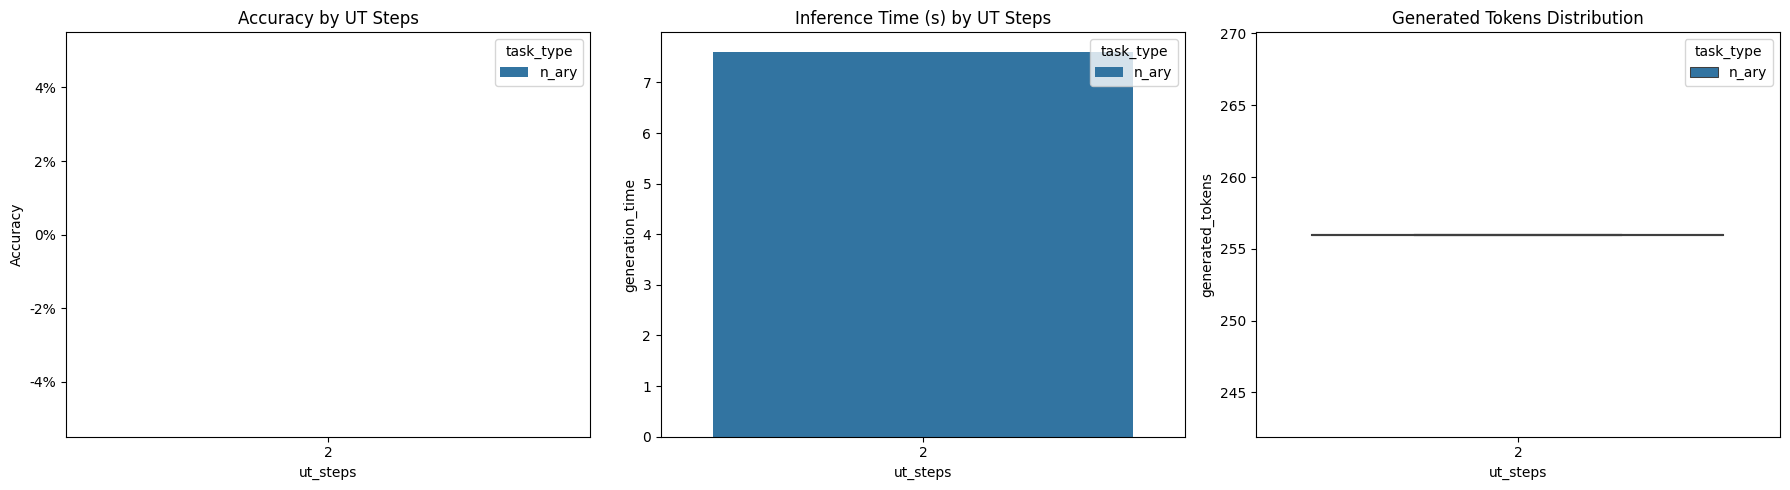


🏁 Experiment Complete.



In [10]:
# 3. Save Results
df_acc = pd.DataFrame(acc_results)
df_ppl = pd.DataFrame(ppl_results)
df_hol = pd.DataFrame(hol_results)
# 4. Visualization & Reporting
if not df_acc.empty:
    print("\n" + "="*50 + "\n📊 VISUALIZATION\n" + "="*50)

    # Summary Tables
    # NOTE: The variable 'results_acc' is used here, assuming it holds the raw data
    # (list of dicts) required by 'analyze_experiment_results'.
    summary = analyze_experiment_results(acc_results)
    print("\n--- Summary Statistics ---")
    print(summary)

    # Plotting
    try:
        fig, axes = plt.subplots(1, 3, figsize=(18, 5))

        # Plot 1: Accuracy
        acc_summary = df_acc.groupby(['task_type', 'ut_steps'])['is_correct'].mean().reset_index()
        sns.barplot(data=acc_summary, x='ut_steps', y='is_correct', hue='task_type', ax=axes[0])
        axes[0].set_title('Accuracy by UT Steps')
        axes[0].set_ylabel('Accuracy')
        axes[0].yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

        # Plot 2: Time
        time_summary = df_acc.groupby(['task_type', 'ut_steps'])['generation_time'].mean().reset_index()
        sns.barplot(data=time_summary, x='ut_steps', y='generation_time', hue='task_type', ax=axes[1])
        axes[1].set_title('Inference Time (s) by UT Steps')

        # Plot 3: Token Count
        sns.boxplot(data=df_acc, x='ut_steps', y='generated_tokens', hue='task_type', ax=axes[2])
        axes[2].set_title('Generated Tokens Distribution')

        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"⚠️ Visualization error: {e}")
else:
    print("⚠️ No results to visualize.")

print("\n🏁 Experiment Complete.\n")

In [11]:
print("Final Inspection:\n")
print("Top 20 Accuracy Report:\n")
print(df_acc.head(20))
print(f"Full Response:\n")
print(df_acc['full_response'])
print("Perplexity Report:\n")
print(df_ppl.head(20))

Final Inspection:

Top 20 Accuracy Report:

   task_type difficulty   test_input expected_answer prediction  is_correct  \
0      n_ary      2_ops  952 + 539 =            1491       6678       False   
1      n_ary      2_ops  377 + 300 =             677         30       False   
2      n_ary      2_ops  745 + 857 =            1602        102       False   
3      n_ary      2_ops  136 + 242 =             378        222       False   
4      n_ary      2_ops  249 + 733 =             982      ERROR       False   
5      n_ary      2_ops  172 + 775 =             947      ERROR       False   
6      n_ary      2_ops  621 + 722 =            1343          1       False   
7      n_ary      2_ops  987 + 391 =            1378       5427       False   
8      n_ary      2_ops  180 + 113 =             293      ERROR       False   
9      n_ary      2_ops  044 + 272 =             316         15       False   
10     n_ary      2_ops  093 + 847 =             940         13       False   
11     n

In [12]:
print(df_acc[['full_response', 'generated_tokens']])

                                        full_response  generated_tokens
0   Step 1:  0 + 539 = 539\nStep 2: 539 + 539 = 11...               256
1   Step 1:  0 + 300 = 300\nStep 2: 300 + 300 = 60...               256
2   Step 1:  0 + 757 = 757\nStep 2: 757 + 857 = 16...               256
3   Step 1:  0 + 136 = 136\nStep 2: 136 + 222 = 35...               256
4   Step 1:  0 + 249 = 249\nStep 2: 249 + 733 = 98...               256
5   Step 1:  0 + 172 = 172\nStep 2: 172 + 775 = 94...               256
6   Step 1:  0 + 611 = 611\nStep 2: 611 + 722 = 13...               256
7   Step 1:  0 + 977 = 977\nStep 2: 977 + 391 = 13...               256
8   Step 1:  0 + 113 = 113\nStep 2: 113 + 113 = 22...               256
9   Step 1:  0 + 44 = 44\nStep 2: 44 + 272 = 316\n...               256
10  Step 1:  0 + 93 = 93\nStep 2: 93 + 877 = 970\n...               256
11  Step 1:  0 + 177 = 177\nStep 2: 177 + 208 = 38...               256
12  Step 1:  0 + 518 = 518\nStep 2: 518 + 777 = 13...           